# Implementation



In [1]:
import math
import numpy as np
import torch
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear": ###chosen in default
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        # scale = 1000 / num_diffusion_timesteps
        beta_start = 0.0001  # scale * 0.0001
        beta_end = 0.02  # scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

betas=get_named_beta_schedule("linear", 200)
alphas = 1.0 - betas
alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
g_t = torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))

In [2]:
import collections
import datetime
import glob
import pathlib

import pandas as pd
import seaborn as sns
# import tensorflow as tf
import os
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from IPython import display
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
from pathlib import Path
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from torch.autograd import Variable
import torch
import numpy as np
from scipy import signal

def plot_specgram(waveform, sample_rate):
    f, t, Sxx = signal.spectrogram(waveform, sample_rate)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

In [3]:
#### Display tools
def plot_this(s,title=''):
    """

    """
    import pylab
    s = s.squeeze()
    if s.ndim ==1:
        pylab.plot(s)
    else:
        pylab.imshow(s,aspect='auto')
        pylab.title(title)
    pylab.show()
    
def reshape_signal(signal, batch_size):
    """
    Reshapes the original signal tensor into batches of the given batch size,
    removing the tail if necessary to make the length divisible by the batch size.
    
    Args:
        signal (torch.Tensor): The original signal tensor, assumed to be 1-dimensional.
        batch_size (int): The desired batch size.
    
    Returns:
        torch.Tensor: Reshaped tensor with shape (batch_size, -1).
    """
    # Flatten the signal in case it's multi-dimensional
    signal = signal.flatten()
    
    # Calculate the maximum length that fits evenly into the batch size
    total_length = signal.size(0)
    length_to_use = (total_length // batch_size) * batch_size
    
    # Truncate the signal to the required length
    truncated_signal = signal[:length_to_use]
    
    # Reshape the signal into (batch_size, -1)
    reshaped_signal = truncated_signal.view(batch_size, -1)
    return reshaped_signal



In [4]:
import torchaudio
train_noise_path = "/data/ephraim/datasets/known_noise/undiff_exps/exp_n_chosen_whole_8/noises/noise_fileid_34.wav"
noise, sr = torchaudio.load(train_noise_path)    
noise_train = noise[:, int(1*sr):int(6*sr)]
noise_test = noise[:, int(6*sr) :]
print("noise_test.shape:", noise_test.shape)

train_ar = reshape_signal(noise_train, batch_size=4)
test_ar = reshape_signal(noise_test, batch_size=1)
print(train_ar.shape)
print(test_ar.shape)

noise_test.shape: torch.Size([1, 64000])
torch.Size([4, 20000])
torch.Size([1, 64000])


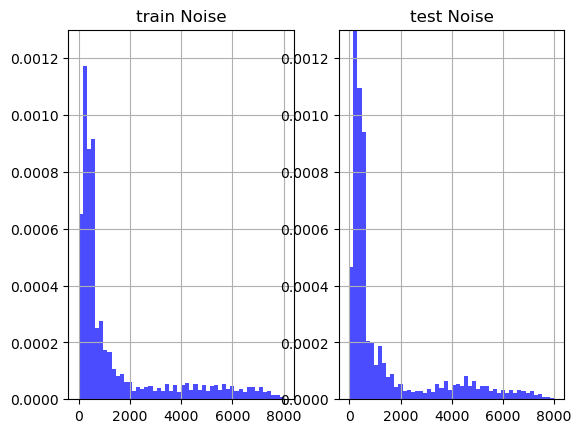

In [5]:

freqs1, magnitudes1 = signal.welch(noise_train.squeeze().cpu().numpy(), fs=16000)
freqs, magnitudes = signal.welch(noise_test.squeeze().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('train Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('test Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

# Data Processing & Preparation.

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset


# Create datasets and data loaders
train_tensor = torch.tensor(train_ar, dtype=torch.float32)#.view(1,1,-1)
test_tensor = torch.tensor(test_ar, dtype=torch.float32)#.view(1,1,-1)
train_tensor.shape


/tmp/ipykernel_2268749/1243974303.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = torch.tensor(train_ar, dtype=torch.float32)#.view(1,1,-1)
/tmp/ipykernel_2268749/1243974303.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.tensor(test_ar, dtype=torch.float32)#.view(1,1,-1)


torch.Size([4, 20000])

In [7]:

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear": ###chosen in default
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        # scale = 1000 / num_diffusion_timesteps
        beta_start = 0.0001  # scale * 0.0001
        beta_end = 0.02  # scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )

betas=get_named_beta_schedule("linear", 200)

alphas = 1.0 - betas
alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
white_noise_diffusion2 = torch.normal(0,1,test_tensor.shape)
g_t = torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))
t = np.random.randint(1,200,1)
cur_g_t = g_t[t]
real_Vtrain = train_tensor + white_noise_diffusion*g_t[t]
real_Vtest = test_tensor + white_noise_diffusion2*g_t[t]
# train_tensor = real_Vtrain
# test_tensor = real_Vtest
real_Vtrain.shape


torch.Size([4, 20000])

In [8]:
train_tensor.shape

torch.Size([4, 20000])

In [9]:
# train_full_tensors = train_tensor.squeeze().repeat(200,1,1).view(dataset_size,200,-1)
dataset_size=1
train_full_tensors = train_tensor.squeeze().view(dataset_size,1,-1)



# train_full_tensors = train_tensor.reshape(dataset_size,200,-1)

for i in [0]:
    cur_white_noise_diffusion = torch.normal(0,1,train_full_tensors[:,i,:].shape)
    train_full_tensors = train_full_tensors[:,i,:]#+cur_white_noise_diffusion*g_t[199]

# test_full_tensors = test_tensor.squeeze().repeat(200,1).view(200,1,-1)
test_full_tensors = test_tensor.squeeze().view(dataset_size,1,-1)

for i in [0]:
    cur_white_noise_diffusion = torch.normal(0,1,test_full_tensors[:,i,:].shape)
    test_full_tensors = test_full_tensors[:,i,:] #+cur_white_noise_diffusion*g_t[199]

print(train_full_tensors.shape)
print(test_full_tensors.shape)

torch.Size([1, 80000])
torch.Size([1, 64000])


In [10]:
import os
import pandas as pd
from torch.utils.data import Dataset


class NoiseDataset(Dataset):
    def __init__(self, data_tensor, gt_tensor):
        self.data_tensor =data_tensor
        self.gt_tensor = gt_tensor

    def __len__(self):
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        item = self.data_tensor[idx,:,:]
        cur_gt = self.gt_tensor[idx]
        return item, cur_gt

class BatchNoiseDataset(Dataset):
    def __init__(self, data_tensor, gt_tensor):
        self.data_tensor =data_tensor
        self.gt_tensor = gt_tensor

    def __len__(self):
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        item = self.data_tensor[idx,:,:]
        cur_gt = self.gt_tensor
        return item, cur_gt


In [11]:
def calc_stft(tensor):

    # Parameters
    sample_rate = 16000  # Sample rate in Hz
    n_fft = 512  # Number of FFT points
    win_length = n_fft  # Window length
    hop_length = int(win_length/2)  # Number of samples between frames
    window = torch.hann_window(win_length)  # Window function

    signal_ = tensor.view(-1)
    duration = max(tensor.shape)

    stft = torch.stft(signal_, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)
    return stft, duration, sample_rate

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    
from scipy.signal import firwin
def fir_filter(tensor, high=False, cutoff=6000,num_taps=101,device="cpu",sample_rate=16000):
    cutoff_freq = cutoff  # Cutoff frequency for the high-pass filter in Hz
    num_taps = num_taps  # Filter order (number of filter coefficients)
    if high:
        pass_zero = False
    else:
        pass_zero = True
    coefficients = firwin(num_taps, cutoff=cutoff_freq, pass_zero=pass_zero, fs=sample_rate)

    # Convert filter coefficients to a PyTorch tensor
    coefficients = torch.tensor(coefficients, dtype=torch.float32).to(device)

    pad_length = (num_taps - 1) // 2
    signal_padded = torch.nn.functional.pad(tensor.view(1, 1, -1), (pad_length, pad_length), mode='constant').to(device)

    # Apply the FIR filter to the signal using convolution
    filtered_signal = torch.nn.functional.conv1d(signal_padded.view(1, 1, -1), coefficients.view(1, 1, -1))
    return filtered_signal

In [12]:
# from IPython import display
# display.display(display.Audio(filtered_signal.view(1,-1), rate=sr))

In [13]:
def compare_spectrograms(original,modified):
    train_tensor_ftft, duration, sample_rate= calc_stft(original)
    filtered_signal_ftft,duration, sample_rate = calc_stft(modified)
    train_tensor_ftft = torch.abs(train_tensor_ftft)
    filtered_signal_ftft = torch.abs(filtered_signal_ftft)
    limit = sample_rate/2

    figure, axis = plt.subplots(1,2)
    vmin = np.vstack([train_tensor_ftft.squeeze(),filtered_signal_ftft.squeeze()]).min()
    vmax = np.vstack([train_tensor_ftft.squeeze(),filtered_signal_ftft.squeeze()]).max()
    im = axis[0].imshow(train_tensor_ftft, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, extent=[0, duration, 0, sample_rate / 2])
    axis[0].set_title('original Noise')
    axis[0].grid(True)
    axis[0].set_ylim(0.0, limit)
    axis[1].imshow(filtered_signal_ftft, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, extent=[0, duration, 0, sample_rate / 2])
    axis[1].set_title('model Noise')
    axis[1].grid(True)
    axis[1].set_ylim(0.0, limit)
    figure.colorbar(im,ax=axis.ravel().tolist(), label='Magnitude')
    plt.show()

In [14]:
train_full_tensors.reshape(dataset_size,1,-1).shape

torch.Size([1, 1, 80000])

In [15]:
def generate_signal_nomog(noise_model,test_full_tensors):
    test_tensors = test_full_tensors.reshape(1,1,-1)
    device="cpu"
    j=0
    long = 501
    window = 20000
    mu_array = torch.zeros((long+window+1))
    sig_array = torch.zeros((long+window+1))

    model = noise_model.to(device)
    cur_input = test_tensors[0,0,:35000].clone().view(1,1,-1)
    cur_input[0,0,window+1:] = 0
    print(cur_input[0,0,window])
    print(cur_input[0,0,window+1])
    cur_input = cur_input.to(device, dtype=torch.float)
    print(cur_input.shape)
# cur_input = cur_train[0,0,:window].view(1,1,-1)

    with torch.no_grad():
        for i in tqdm(range(test_tensors.shape[2]-window)):
            if i >long:
                continue
        
            tensor_ = cur_input[0,0,:window+i+1].view(1,1,-1)
            mu,sig = model(tensor_,g_t[j].to(device))
            del tensor_
            mu_ = mu[0,-1].cpu()
            sig_ = sig[0,-1].cpu()
        
            mu_array[window+i] = mu_
            sig_array[window+i] = sig_
            added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
        # print(mu_,sig_,added)
            cur_input[0,0,window+i+1] = added
            del mu_, sig_, #mu, sig
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
    return cur_input,window



def plot_spec(test_tensors,cur_input, window):
    freqs1, magnitudes1 = signal.welch(test_tensors[0,0,window:window+500].squeeze().cpu().detach().numpy(), fs=16000)
    freqs, magnitudes = signal.welch(cur_input[0,0,window:window+500].squeeze().detach().cpu(), fs=16000)
    limit = 0.0013
    figure, axis = plt.subplots(1,2)
    axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
    axis[0].set_title('original Noise')
    axis[0].grid(True)
    axis[0].set_ylim(0.0, limit)
    axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
    axis[1].set_title('model Noise')
    axis[1].grid(True)
    axis[1].set_ylim(0.0, limit)
    plt.show()


In [16]:
import torch
import torch.nn.functional as F
import math

@torch.no_grad()
def generate_signal(model, 
                    initial_signal, 
                    num_samples=16000, 
                    device='cpu'):
    """
    Autoregressively generate a 1D signal from a trained MoG model.
    
    Parameters
    ----------
    model : nn.Module
        Your NetworkNoise6MoG model (or similar) that outputs (logits, means, log_sig).
    initial_signal : 1D or 2D torch.Tensor
        The starting samples of shape (init_length,) or (1, init_length).
        We'll treat this as the "warm-up" or "prompt."
    num_samples : int
        How many total output samples to generate (beyond the initial signal length).
    device : str
        Which device to run on ('cpu' or 'cuda').

    Returns
    -------
    generated : torch.Tensor
        A 1D tensor of length (initial_length + num_samples) containing the generated waveform.
    """
    model.eval()  # no dropout, no batchnorm updates

    # Make sure we have shape (1, 1, T)
    if initial_signal.dim() == 1:
        # shape => (1, 1, T)
        initial_signal = initial_signal.unsqueeze(0).unsqueeze(0)
    elif initial_signal.dim() == 2:
        # shape => (1, B, T) ?? We'll assume (1, T) => make (1, 1, T)
        initial_signal = initial_signal.unsqueeze(0)
    else:
        raise ValueError("initial_signal must be 1D or 2D tensor")

    initial_signal = initial_signal.to(device)
    generated_signal = initial_signal.clone()  # (1, 1, T_init)

    # Current length
    current_length = generated_signal.size(-1)

    for step in tqdm(range(num_samples)):
        # 1) Run model on all known samples so far
        logits, means, log_sig = model(generated_signal, "None")
        # logits, means, log_sig are shape (1, K, T_so_far)

        # 2) We want the distribution for the *last* time index => T_so_far - 1
        #    i.e. the newly predicted sample index
        t_idx = logits.size(-1) - 1  # last position

        # alpha_k = softmax over mixture dimension
        alpha = F.softmax(logits[:, :, t_idx], dim=1)  # shape (1, K)
        mu    = means[:, :, t_idx]                     # shape (1, K)
        s     = torch.exp(log_sig[:, :, t_idx])        # shape (1, K)
        
        # 3) Sample from the mixture
        # Pick which component k using alpha
        alpha = alpha.squeeze(0)  # (K,)
        mu    = mu.squeeze(0)     # (K,)
        s     = s.squeeze(0)      # (K,)

        # Choose mixture index k with probability alpha
        k = torch.multinomial(alpha, num_samples=1)  # shape (1,)

        # 4) Sample from Gaussian N(mu_k, s_k^2)
        chosen_mu = mu[k]
        chosen_s  = s[k]
        new_sample = torch.randn(1, device=device) * chosen_s + chosen_mu

        # 5) Append the new sample to the generated signal
        new_sample_reshaped = new_sample.view(1, 1, 1)  # (1, 1, 1)
        generated_signal = torch.cat([generated_signal, new_sample_reshaped], dim=-1)

    # Return shape => (T_final,) i.e. flatten out
    generated_signal = generated_signal.squeeze(0).squeeze(0)
    return generated_signal.cpu()


In [55]:
device="cpu"
from create_exp_m import NetworkNoise7, NetworkNoise6,NetworkNoise5,NetworkNoise4, NetworkNoise3, WaveNetCausalModel, NetworkNoise6MoG, NetworkNoiseWaveNetMoG#,NetworkNoise8
# from train_on_all_noises_8 import WaveNet
# from train_on_all_noises_8_gt import NetworkNoise8


# noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/pure_noises_net6/model_step62000.pth"
# noise_model = NetworkNoise6()
noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/pure_noises_net4/model_step62000.pth"
noise_model = NetworkNoise4()

noise_model.load_state_dict(torch.load(noise_model_path, map_location=torch.device(device))['model_state'])
noise_model.eval()
noise_model.to(device)
# noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/pure_noises_net6_mog/model_step62000.pth"
# noise_model = NetworkNoise6MoG(num_mixtures=50)
# mog=True


NetworkNoise4(
  (conv1): CausalConv1dClassS(1, 2, kernel_size=(9,), stride=(1,), padding=(8,))
  (tanh1): Tanh()
  (conv2): CausalConv1dClassS(2, 2, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
  (tanh2): Tanh()
  (conv3): CausalConv1dClassS(2, 2, kernel_size=(9,), stride=(1,), padding=(32,), dilation=(4,))
  (tanh3): Tanh()
  (conv4): CausalConv1dClassS(2, 2, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(8,))
  (tanh4): Tanh()
  (conv5): CausalConv1dClassS(2, 2, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(8,))
  (tanh5): Tanh()
  (conv6): CausalConv1dClassS(2, 2, kernel_size=(9,), stride=(1,), padding=(32,), dilation=(4,))
  (tanh6): Tanh()
  (conv7): CausalConv1dClassS(2, 2, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
  (tanh7): Tanh()
  (conv8): CausalConv1dClassS(2, 2, kernel_size=(9,), stride=(1,), padding=(8,))
)

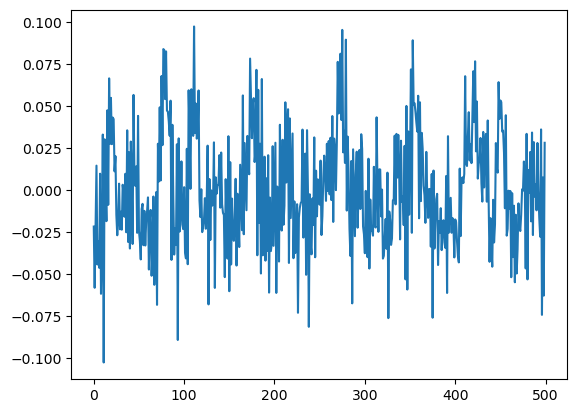

In [56]:
output = noise_model(test_full_tensors.view(1,1,-1).to(device),g_t[0].to(device))
plot_this(output[0][:,0:500].cpu().detach().numpy())

In [57]:

cur_input,window = generate_signal_nomog(noise_model,test_full_tensors)


tensor(-0.0058)
tensor(0.)
torch.Size([1, 1, 35000])


/tmp/ipykernel_1725257/1833608449.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(test_tensors.shape[2]-window)):


  0%|          | 0/44000 [00:00<?, ?it/s]

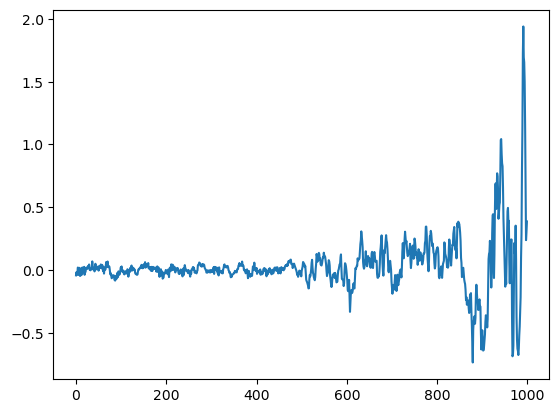

In [58]:
plot_this(cur_input.reshape(1,1,-1)[0,0,window-500:window+500].cpu().detach().numpy())

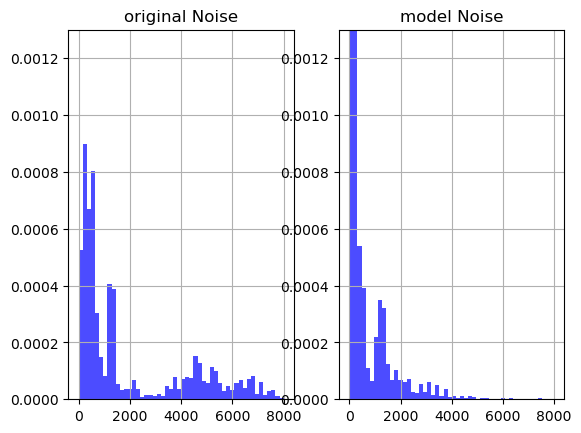

In [59]:
plot_spec(test_full_tensors.reshape(1,1,-1),cur_input, window)

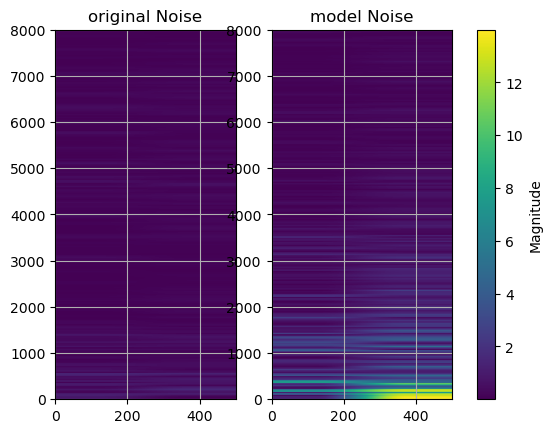

In [62]:
test_tensors = test_full_tensors.reshape(1,1,-1)
compare_spectrograms(test_tensors[0,0,window:window+500].detach().squeeze().cpu(),cur_input[0,0,window:window+500].detach().squeeze().cpu())

In [36]:
device="cpu"
from create_exp_m import NetworkNoise7, NetworkNoise6,NetworkNoise5,NetworkNoise4, NetworkNoise3, WaveNetCausalModel, NetworkNoise6MoG, NetworkNoiseWaveNetMoG#,NetworkNoise8
# from train_on_all_noises_8 import WaveNet
# from train_on_all_noises_8_gt import NetworkNoise8

# noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/all_noises_net8b/model_step2721000.pth"
# noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/all_noises_net8b/model_step175350.pth"
# noise_model = NetworkNoise8()

# noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/all_noises_net3/model_step3265100.pth"
# noise_model = NetworkNoise3()

# noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/pure_noises_net6/model_step62000.pth"
# noise_model = NetworkNoise6()


noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/pure_noises_netwavenet/model_step85000.pth"
noise_model = WaveNetCausalModel()
mog=False



noise_model.load_state_dict(torch.load(noise_model_path, map_location=torch.device(device))['model_state'])
noise_model.eval()
noise_model.to(device)
# noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/pure_noises_net6_mog/model_step62000.pth"
# noise_model = NetworkNoise6MoG(num_mixtures=50)
# mog=True


WaveNetCausalModel(
  (blocks): ModuleList(
    (0): GatedResidualBlock(
      (conv_in): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
      (conv_filter): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(8,))
      (conv_gate): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(8,))
      (conv_skip): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
      (conv_out): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
      (tanh): Tanh()
      (sigmoid): Sigmoid()
    )
    (1): GatedResidualBlock(
      (conv_in): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
      (conv_filter): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
      (conv_gate): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
      (conv_skip): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
      (conv_out): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
      (tanh): Tanh()
      (sigmoid): Sigmoid()
    )
    (2): GatedResidualBloc

In [37]:
test_full_tensors.shape

torch.Size([1, 64000])

In [38]:
output = noise_model(test_full_tensors.view(1,1,-1).to(device),g_t[0].to(device))

In [39]:
output[0].shape

torch.Size([1, 64000])

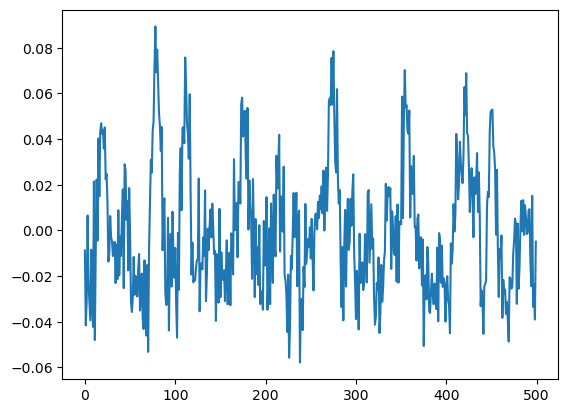

In [40]:
plot_this(test_full_tensors[:,0:500].cpu().detach().numpy())

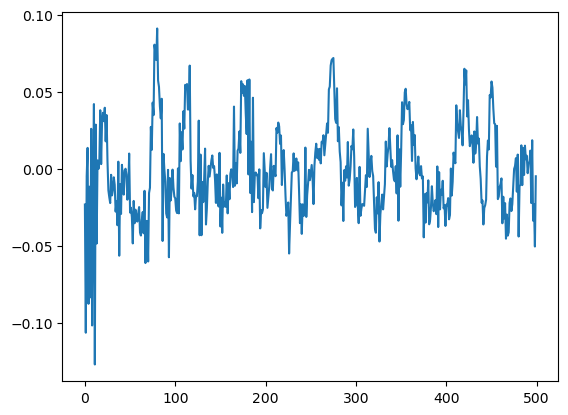

In [41]:
plot_this(output[0][:,0:500].cpu().detach().numpy())

In [42]:
test_tensors = test_full_tensors.reshape(1,1,-1)
device="cpu"
j=0
long = 501
window = 20000
mu_array = torch.zeros((long+window+1))
sig_array = torch.zeros((long+window+1))

model = noise_model.to(device)
cur_input = test_tensors[0,0,:35000].clone().view(1,1,-1)
cur_input[0,0,window+1:] = 0
print(cur_input[0,0,window])
print(cur_input[0,0,window+1])
cur_input = cur_input.to(device, dtype=torch.float)
print(cur_input.shape)
# cur_input = cur_train[0,0,:window].view(1,1,-1)

with torch.no_grad():
    for i in tqdm(range(test_tensors.shape[2]-window)):
        if i >long:
            continue
        
        tensor_ = cur_input[0,0,:window+i+1].view(1,1,-1)
        mu,sig = model(tensor_,g_t[j].to(device))
        del tensor_
        mu_ = mu[0,-1].cpu()
        sig_ = sig[0,-1].cpu()
        
        mu_array[window+i] = mu_
        sig_array[window+i] = sig_
        added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
        # print(mu_,sig_,added)
        cur_input[0,0,window+i+1] = added
        del mu_, sig_, #mu, sig
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect() 

tensor(-0.0058)
tensor(0.)
torch.Size([1, 1, 35000])


/tmp/ipykernel_1725257/3520283937.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(test_tensors.shape[2]-window)):


  0%|          | 0/44000 [00:00<?, ?it/s]

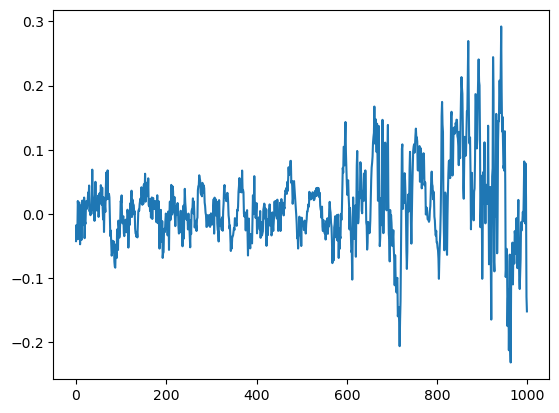

In [47]:
plot_this(cur_input.reshape(1,1,-1)[0,0,window-500:window+500].cpu().detach().numpy())

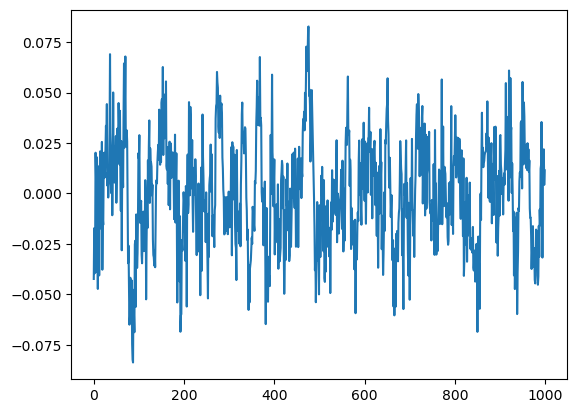

In [48]:
plot_this(test_tensors[0,0,window-500:window+500].cpu().detach().numpy())

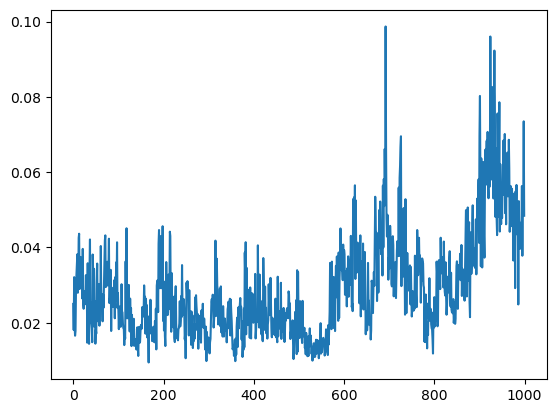

In [49]:
plot_this(sig[0,window-500:window+500].cpu().detach().numpy())

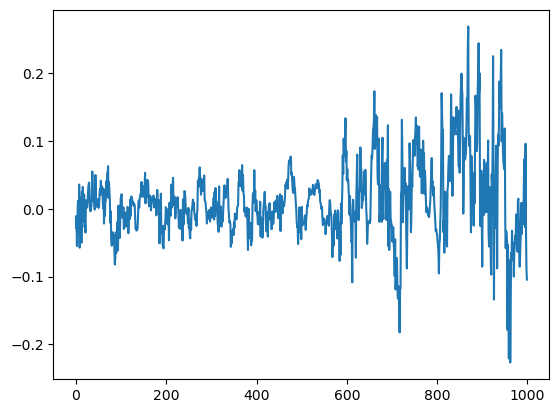

In [50]:
plot_this(mu[0,window-500:window+500].cpu().detach().numpy())

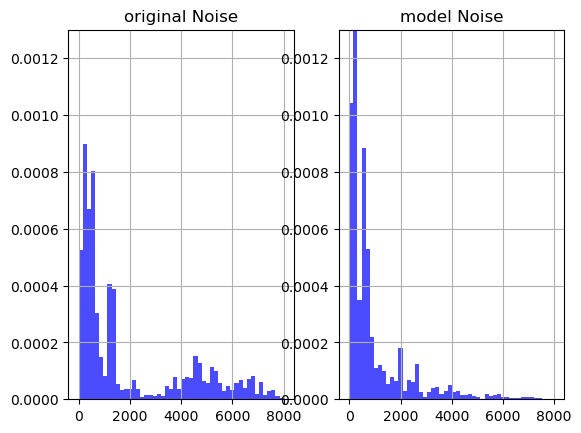

In [53]:

plot_spec(test_tensors,cur_input, window)



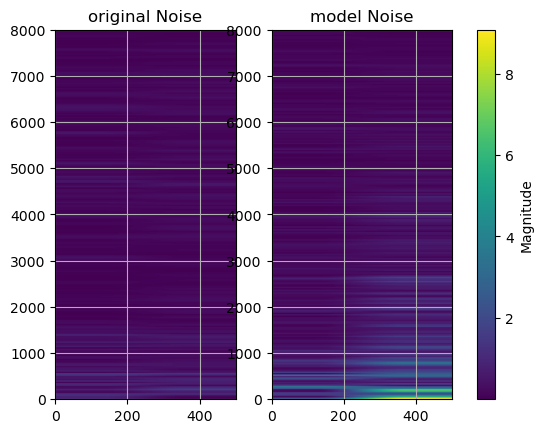

In [54]:
compare_spectrograms(test_tensors[0,0,window:window+500].detach().squeeze().cpu(),cur_input[0,0,window:window+500].detach().squeeze().cpu())

In [17]:
from create_exp_m import NetworkNoiseWaveNetMoG
# noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/pure_noises_netwavenet_mog/model_step27000.pth"
noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/pure_noises_netwavenet_mog/model_step320000.pth"
noise_model = NetworkNoiseWaveNetMoG()
mog=True



noise_model.load_state_dict(torch.load(noise_model_path, map_location=torch.device(device))['model_state'])
noise_model.eval()
noise_model.to(device)

/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


NameError: name 'device' is not defined

In [18]:
test_tensors = test_full_tensors.reshape(1,1,-1)
device="cpu"
j=0
long = 501
window = 20000
mu_array = torch.zeros((long+window+1))
sig_array = torch.zeros((long+window+1))

model = noise_model.to(device)
cur_input = test_tensors[0,0,:35000].clone().view(1,1,-1)
cur_input[0,0,window+1:] = 0
print(cur_input[0,0,window])
print(cur_input[0,0,window+1])
cur_input = cur_input.to(device, dtype=torch.float)
print(cur_input.shape)
generated = generate_signal(
    model=noise_model,
    initial_signal=cur_input[:,:,:window].squeeze(),
    num_samples=500,  # generate 2000 new samples
    device='cpu'
)
cur_input = generated.reshape(1,1,-1)

tensor(-0.0058)
tensor(0.)
torch.Size([1, 1, 35000])


/tmp/ipykernel_2268749/3360710754.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(num_samples)):


  0%|          | 0/500 [00:00<?, ?it/s]

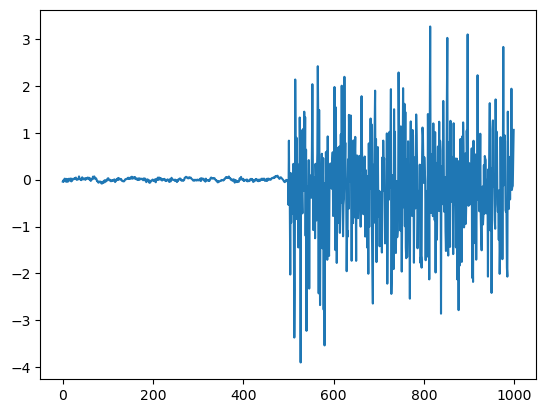

In [19]:
plot_this(cur_input[0,0,window-500:window+500].cpu().detach().numpy())

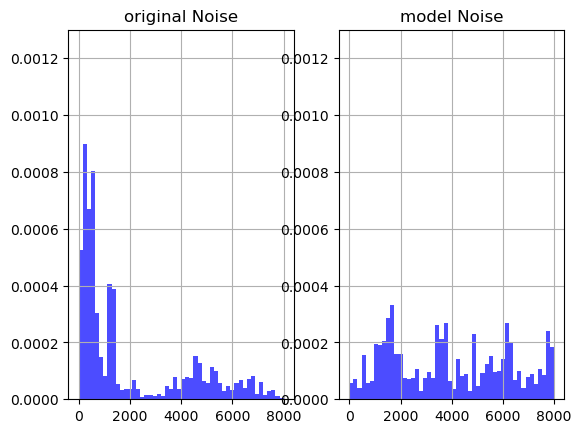

In [20]:
freqs1, magnitudes1 = signal.welch(test_tensors[0,0,window:window+500].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input[0,0,window:window+500].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [21]:
from create_exp_m import NetworkNoiseWaveNetMoG2
noise_model_path = "/data/ephraim/datasets/known_noise/undiff_exps/training_all/pure_noises_netwavenet_mog2/model_step310000.pth"
noise_model = NetworkNoiseWaveNetMoG2(num_mixtures=5)


noise_model.load_state_dict(torch.load(noise_model_path, map_location=torch.device(device))['model_state'])
noise_model.eval()
noise_model.to(device)

NetworkNoiseWaveNetMoG2(
  (causal_in): CausalConv1dClassS(1, 32, kernel_size=(1,), stride=(1,))
  (blocks): ModuleList(
    (0): GatedResidualBlock(
      (conv_in): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      (conv_filter): CausalConv1dClassS(32, 32, kernel_size=(9,), stride=(1,), padding=(8,))
      (conv_gate): CausalConv1dClassS(32, 32, kernel_size=(9,), stride=(1,), padding=(8,))
      (conv_skip): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (conv_out): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      (tanh): Tanh()
      (sigmoid): Sigmoid()
    )
    (1): GatedResidualBlock(
      (conv_in): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      (conv_filter): CausalConv1dClassS(32, 32, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
      (conv_gate): CausalConv1dClassS(32, 32, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
      (conv_skip): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (conv_out): Conv1d(32, 32, kernel_size=(1

In [22]:
test_tensors = test_full_tensors.reshape(1,1,-1)
device="cpu"
j=0
long = 501
window = 20000
mu_array = torch.zeros((long+window+1))
sig_array = torch.zeros((long+window+1))

model = noise_model.to(device)
cur_input = test_tensors[0,0,:35000].clone().view(1,1,-1)
cur_input[0,0,window+1:] = 0
print(cur_input[0,0,window])
print(cur_input[0,0,window+1])
cur_input = cur_input.to(device, dtype=torch.float)
print(cur_input.shape)
generated = generate_signal(
    model=noise_model,
    initial_signal=cur_input[:,:,:window].squeeze(),
    num_samples=500,  # generate 2000 new samples
    device='cpu'
)
cur_input = generated.reshape(1,1,-1)

tensor(-0.0058)
tensor(0.)
torch.Size([1, 1, 35000])


/tmp/ipykernel_2268749/3360710754.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(num_samples)):


  0%|          | 0/500 [00:00<?, ?it/s]

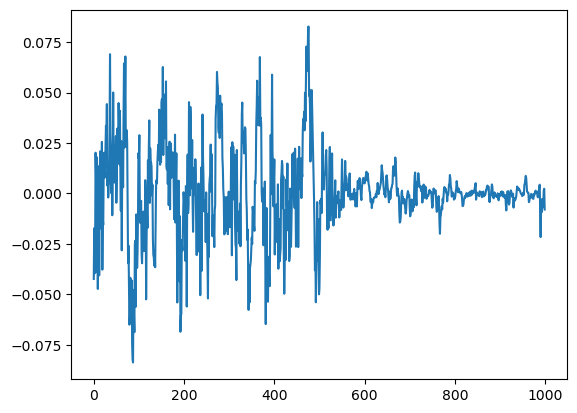

In [23]:
plot_this(cur_input[0,0,window-500:window+500].cpu().detach().numpy())

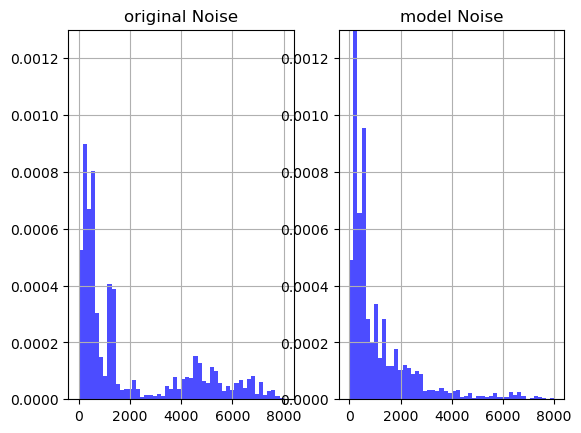

In [24]:
freqs1, magnitudes1 = signal.welch(test_tensors[0,0,window:window+500].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input[0,0,window:window+500].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [ ]:
ar_coefs = [ 0.4,-0.1, 0.1, -0.05,0.03]

In [ ]:
class DummyModel(torch.nn.Module):
    """A dummy model for testing purposes."""
    def forward(self, input_tensor):
        ar_coefficients = [0.9]
        sigma_epsilon = 1  # Process noise std deviation
        sigma_eta = 0.01      # Observation noise std deviation
        mean, std = predict_next_point(input_tensor, ar_coefficients, sigma_epsilon, sigma_eta)
        return mean, std
    



def predict_next_point(y_observations, ar_coefficients, sigma_epsilon, sigma_eta):
    """
    Predict the mean and standard deviation of the next point in a signal
    that is an AR process plus white noise.
    
    Parameters:
    - y_observations: list or array of observed signal values (y_t).
    - ar_coefficients: list or array of AR coefficients [a1, a2, ..., ap].
    - sigma_epsilon: standard deviation of the AR process noise (epsilon_t).
    - sigma_eta: standard deviation of the observation noise (eta_t).
    
    Returns:
    - mean_pred: predicted mean of y_{t+1}.
    - std_pred: predicted standard deviation of y_{t+1}.
    """
    # Order of the AR process
    p = len(ar_coefficients)
    
    # Number of observations
    N = len(y_observations)
    
    # Initialize state vector (x_hat) and covariance matrix (P)
    # For simplicity, initialize the state estimate with zeros
    x_hat = np.zeros((p, 1))
    
    # Initialize covariance matrix with large values
    P = np.eye(p) * 1e5  # Large initial uncertainty
    
    # State transition matrix (A)
    A = np.zeros((p, p))
    A[0, :] = ar_coefficients
    A[1:, :-1] = np.eye(p - 1)
    
    # Observation matrix (H)
    H = np.zeros((1, p))
    H[0, 0] = 1.0
    
    # Process noise covariance (Q)
    Q = np.zeros((p, p))
    Q[0, 0] = sigma_epsilon**2  # Only the first element has process noise
    
    # Observation noise covariance (R)
    R = np.array([[sigma_eta**2]])
    
    # Kalman filter iterations
    for t in range(N):
        # Predict Step
        x_pred = A @ x_hat
        P_pred = A @ P @ A.T + Q
        
        # Update Step
        y_t = y_observations[t]
        y_pred = H @ x_pred
        nu = y_t - y_pred  # Innovation
        S = H @ P_pred @ H.T + R  # Innovation covariance
        K = P_pred @ H.T / S  # Kalman gain
        x_hat = x_pred + K * nu
        P = (np.eye(p) - K @ H) @ P_pred
        
    # After processing all observations, predict the next point
    # Predict the state at t+1
    x_pred = A @ x_hat
    P_pred = A @ P @ A.T + Q
    
    # Predict the observation at t+1
    y_pred = H @ x_pred
    S = H @ P_pred @ H.T + R  # Predicted observation variance
    
    mean_pred = y_pred.item()
    std_pred = np.sqrt(S.item())
    
    return mean_pred, std_pred

In [ ]:
model3 = DummyModel()
long = 1000
window = 20000
mu_array3 = torch.zeros((long+window+1))
sig_array3 = torch.zeros((long+window+1))

model = model.to("cuda:2")
cur_input3 = train_inputs[1,0,:35000].clone().view(1,1,-1)
cur_input3[0,0,window+1:] = 0
print(cur_input3[0,0,window])
print(cur_input3[0,0,window+1])
cur_input3 = cur_input3.to("cuda:2", dtype=torch.float)
print(cur_input3.shape)

for i in tqdm(range(long)):
    if i >long:
        continue

    # mu,sig = model3(cur_input3[0,0,:window+i+1].view(-1).cpu() )
    ar_coefficients = [0.9]
    sigma_epsilon = 1  # Process noise std deviation
    sigma_eta = 0.01      # Observation noise std deviation
    mu_, sig_ = predict_next_point(cur_input3[0,0,:window+i+1].cpu().numpy(), ar_coefficients, sigma_epsilon, sigma_eta)
    # mu_ = mu[0,-1]
    # sig_ = sig[0,-1]
    
    mu_array3[window+i] = mu_
    sig_array3[window+i] = sig_
    added = torch.normal(float(mu_), float(sig_),(1,1))#.reshape(1,1,1)
    # print(mu_,sig_,added)
    cur_input3[0,0,window+i+1] = added

    torch.cuda.empty_cache()

tensor(-0.9950, device='cuda:0')
tensor(0., device='cuda:0')
torch.Size([1, 1, 35000])


/tmp/ipykernel_117571/3884819426.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(long)):


  0%|          | 0/1000 [00:00<?, ?it/s]

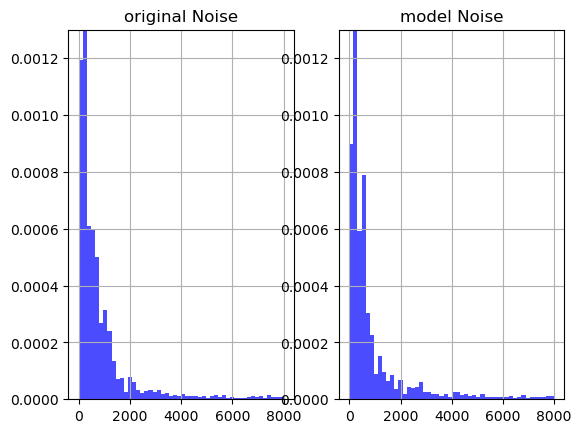

In [ ]:
freqs1, magnitudes1 = signal.welch(train_inputs[0,0,window:window+1000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input3[0,0,window:window+1000].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [ ]:
test_inputs_low.shape

torch.Size([1, 1, 16000])

start 


/tmp/ipykernel_117571/1833417153.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/150 [00:00<?, ?it/s]

0
50
100
Model 0 Epoch 150/150, Loss: 25434260.0625, test Loss: 22764.83203125
4800


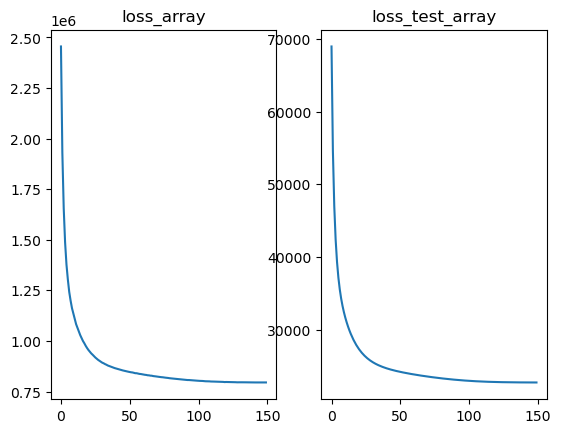

In [ ]:
import torch.optim as optim
high = True
nets_simple = [Network() for i in range(200)]
epochs = 150

loss_array = {}
loss_test_array = {}
i=0
train_dataset = BatchNoiseDataset(train_full_tensors.reshape(dataset_size,1,-1),g_t[i])
test_dataset = BatchNoiseDataset(test_full_tensors.reshape(dataset_size,1,-1),g_t[i])

#Create DataLoaders
train_loader2 = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True) #todo: numbers
test_loader2 = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)


nets_simple,loss_array_high2,loss_test_array_high2 = train(steps=[0],nets=nets_simple,train_loader=train_loader2,test_loader=test_loader2)

plot_loss(loss_array_high2,loss_test_array_high2,0)

In [ ]:
model2=nets_simple[0]
model2.eval()
for batch_idx, (train_inputs2, gt_test) in enumerate(train_loader2):
    break
# test_inputs, gt_test = test_dataset.__getitem__(j)
train_inputs2 = train_inputs2.to("cuda", dtype=torch.float)



Network(
  (conv1): Conv1d(1, 2, kernel_size=(3,), stride=(1,), padding=(3,))
)

In [ ]:
long = 10000
window = 20000
mu_array2 = torch.zeros((long+window+1))
sig_array2 = torch.zeros((long+window+1))

model2 = model2.to("cuda:2")
cur_input2 = train_inputs2[1,0,:35000].clone().view(1,1,-1)
cur_input2[0,0,window+1:] = 0
print(cur_input2[0,0,window])
print(cur_input2[0,0,window+1])
cur_input2 = cur_input2.to("cuda:2", dtype=torch.float)
print(cur_input2.shape)
# cur_input = cur_train[0,0,:window].view(1,1,-1)
for i in tqdm(range(train_inputs2.shape[2]-window)):
    if i >long:
        continue

    mu,sig = model2(cur_input2[0,0,:window+i+1].view(1,1,-1),g_t[j])
    mu_ = mu[0,-1]
    sig_ = sig[0,-1]
    
    mu_array2[window+i] = mu_
    sig_array2[window+i] = sig_
    added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
    # print(mu_,sig_,added)
    cur_input2[0,0,window+i+1] = added

    torch.cuda.empty_cache()

tensor(2.8763, device='cuda:0')
tensor(0., device='cuda:0')
torch.Size([1, 1, 35000])


/tmp/ipykernel_117571/3703299758.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(train_inputs2.shape[2]-window)):


  0%|          | 0/540000 [00:00<?, ?it/s]

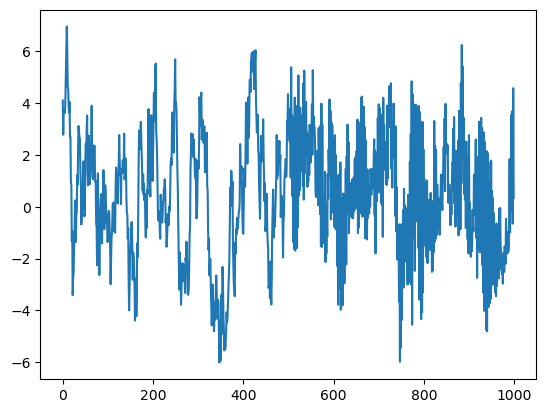

In [ ]:
plot_this(cur_input2[0,0,window-500:window+500].cpu().detach().numpy())

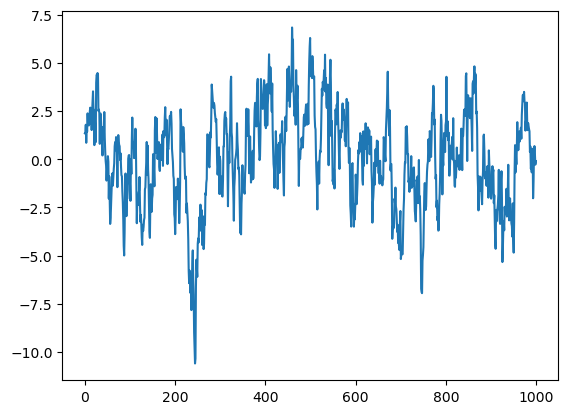

In [ ]:
plot_this(train_inputs2[0,0,window-500:window+500].cpu().detach().numpy())

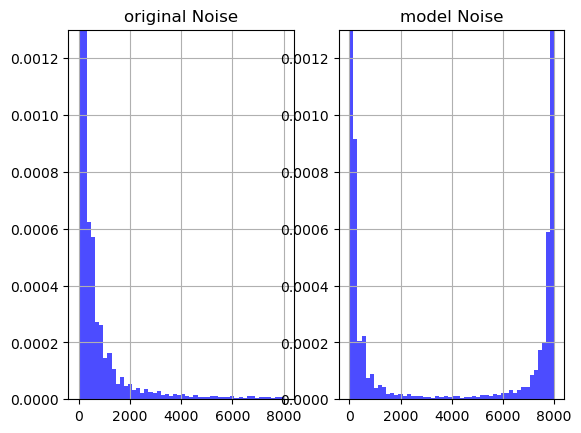

In [ ]:
freqs1, magnitudes1 = signal.welch(train_inputs2[0,0,window:window+5000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input2[0,0,window:window+5000].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# class CausalConv1d(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
#         super(CausalConv1d, self).__init__()
#         self.kernel_size = kernel_size
#         self.dilation = dilation
#         self.padding = (kernel_size - 1) * dilation
#         self.conv = nn.Conv1d(
#             in_channels,
#             out_channels,
#             kernel_size=kernel_size,
#             dilation=dilation
#         )

#     def forward(self, x):
#         # Pad on the left: (left, right) = (self.padding, 0)
#         # This ensures that at time-step t, the convolution can only see up to t-1.
#         x = F.pad(x, (self.padding, 0))
#         return self.conv(x)

# class NetworkG(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # One causal convolution layer producing mean and log_var
#         self.conv1 = CausalConv1d(1, 2, kernel_size=30, dilation=1)

#     def forward(self, x, gt_):
#         # x shape: (B, 1, T)
#         x = self.conv1(x)  # (B, 2, T)
#         means = x[:,0,:]
#         log_var = x[:,1,:]
#         stds = torch.exp(0.5 * log_var)
#         return means, stds
    
#     def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
#         # expected_means, expected_stds, wav_tensor shape: (B, T)
#         # Gaussian log-likelihood:
#         # log p(x|mu,sigma) = -0.5 * [log(2*pi) + 2*log(sigma) + ((x - mu)^2 / sigma^2)]
        
#         wav_tensor = wav_tensor.squeeze(1)  # (B,T) if originally (B,1,T)
#         means_ = expected_means
#         stds_ = expected_stds
        
#         # Compute log-likelihood per time step
#         # -0.5 * log(2π)
#         c = -0.5 * math.log(2 * math.pi)
#         log_probs = c - torch.log(stds_) - 0.5 * ((wav_tensor - means_)**2 / (stds_**2))
#         # sum over time
#         model_likelihood = torch.sum(log_probs, dim=-1)
        
#         if verbose:
#             print("model_likelihood: ", model_likelihood)
        
#         return model_likelihood
    
#     def casual_loss(self, expected_means, expected_stds, wav_tensor):
#         # Negative sum of log-likelihood
#         model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
#         return -model_likelihood.mean()
    
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=13, dilation=1):
        super(CausalConv1d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.padding = (kernel_size - 1) * dilation
        # No padding set in Conv1d, we will handle it manually via F.pad
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=0,
            bias=True
        )

    def forward(self, x):
        # x: (B, C, T)
        # Left pad: (left_pad, right_pad) = (self.padding, 0)
        # After padding: length = T + self.padding
        # Convolution with kernel_size=3, dilation=1 reduces length by 2 steps:
        # Output length = (T + padding - (kernel_size - 1)*dilation) = T
        x = F.pad(x, (self.padding, 0))
        x = self.conv(x)
        # No slicing needed. The output length = T matches the original input length.
        return x

class NetworkG(nn.Module):
    def __init__(self):
        super().__init__()
        # Example: One causal convolution layer
        self.conv1 = CausalConv1d(1, 2, kernel_size=3, dilation=1)

    def forward(self, x,gt_):
        # x: (B, 1, T)
        x = self.conv1(x)  # (B, 2, T)
        means = x[:,0,:]
        log_var = x[:,1,:]
        stds = torch.exp(0.5 * log_var)
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        # wav_tensor: (B, 1, T)
        wav_tensor = wav_tensor.squeeze(1)  # (B,T)
        c = -0.5 * math.log(2 * math.pi)
        log_probs = c - torch.log(expected_stds) - 0.5 * ((wav_tensor - expected_means)**2 / (expected_stds**2))
        model_likelihood = torch.sum(log_probs, dim=-1)  # sum over time

        if verbose:
            print("model_likelihood: ", model_likelihood)
        return model_likelihood
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood.mean()


In [ ]:
from torch import nn
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
   pad = (kernel_size - 1) * dilation +1
   return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)


class CausalConv1dClass(nn.Conv1d):
    def __init__(self,in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        pad = (kernel_size - 1) * dilation +1
        super().__init__(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)
    
    def forward(self, inputs):
        output = super().forward(inputs)
        if self.padding[0] != 0:
            output = output[:, :, :-self.padding[0]-1]
        return output



class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CausalConv1dClass(1, 2, kernel_size=30, dilation=1)

    def forward(self, x, cur_gt):
        x = self.conv1(x)
        # print("self.conv1.padding: ", self.conv1.padding)
        # if self.conv1.padding[0] != 0:
        #     x = x[:, :, :-self.conv1.padding[0]-1]  # remove trailing padding
        means = x[:,0,:]
        log_var = x[:,1,:]
        stds = torch.exp(0.5 *log_var)
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze()
        means_=expected_means.squeeze()
        stds_ = expected_stds.squeeze()

        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood

In [39]:
from torch import nn

class CausalConv1dClassS(nn.Conv1d):
    def __init__(self,in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        pad = (kernel_size - 1) * dilation
        super().__init__(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)
    
    def forward(self, inputs):
        output = super().forward(inputs)
        if self.padding[0] != 0:
            output = output[:, :, :-self.padding[0]]
        return output

class CausalConv1dClass1(nn.Conv1d):
    def __init__(self,in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        pad = (kernel_size - 1) * dilation+1
        super().__init__(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)
    
    def forward(self, inputs):
        # inputs = F.pad(inputs, (1, 0), mode='constant', value=0)
        output = super().forward(inputs)
        if self.padding[0] != 0:
            output = output[:, :, :-self.padding[0]-1]
        return output



class NetworkNoise(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CausalConv1dClass(1, 2, kernel_size=1, dilation=1)
        # self.tanh = nn.Tanh()
        # self.conv2 = CausalConv1dClass(2, 2, kernel_size=5, dilation=1)
        # self.b = nn.Parameter(torch.tensor(0.5))  # Initial value of 'b'


    def forward(self, x, cur_gt):

        x = self.conv1(x)
        # x = self.tanh(x)
        # x = self.conv2(x)

        means = x[:,0,:]
        log_var = x[:,1,:]
        stds = torch.exp(0.5 *log_var)
        # stds = torch.ones_like(means)*self.b
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze(axis=1)[:,4:]
        means_=expected_means.squeeze(axis=1)[:,3:-1]
        stds_ = expected_stds.squeeze(axis=1)[:,3:-1]
        # print(wav_tensor.shape)
        # print(means_.shape)

        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood   



class CausalConv1dClassS(nn.Conv1d):
    def __init__(self,in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        pad = (kernel_size - 1) * dilation
        super().__init__(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)
    
    def forward(self, inputs):
        output = super().forward(inputs)
        if self.padding[0] != 0:
            output = output[:, :, :-self.padding[0]]
        return output
    

class NetworkNoise3(nn.Module):
    def __init__(self, kernel_size=9):
        super().__init__()
        self.kernel_size=kernel_size
        self.conv1 = CausalConv1dClassS(1, 2, kernel_size=kernel_size, dilation=1)
        self.tanh1 = nn.Tanh()
        self.conv2 = CausalConv1dClassS(2, 2, kernel_size=kernel_size, dilation=2)
        self.tanh2 = nn.Tanh()
        self.conv3 = CausalConv1dClassS(2, 2, kernel_size=kernel_size, dilation=4)
        self.tanh3 = nn.Tanh()
        self.conv4 = CausalConv1dClassS(2, 2, kernel_size=kernel_size, dilation=8)
        # self.b = nn.Parameter(torch.tensor(0.5))  # Initial value of 'b'


    def forward(self, x, cur_gt):

        x1 = self.conv1(x)
        x = self.tanh1(x1)
        x = self.conv2(x)
        x = self.tanh2(x)
        x = self.conv3(x)
        x = self.tanh3(x)
        x = self.conv4(x)
        x = x+x1

        means = x[:,0,:]
        log_var = x[:,1,:]
        stds = torch.exp(0.5 *log_var)
        # stds = torch.ones_like(means)*self.b
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze(axis=1)[:,self.kernel_size+1:]
        means_=expected_means.squeeze(axis=1)[:,self.kernel_size:-1]
        stds_ = expected_stds.squeeze(axis=1)[:,self.kernel_size:-1]
        # print(wav_tensor.shape)
        # print(means_.shape)

        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        likelihood = model_likelihood1 + model_likelihood2
        return likelihood.mean()
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood   
    





In [26]:
dataset_size

1

start 


/tmp/ipykernel_166621/1810361886.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/8000 [00:00<?, ?it/s]

0
1000
2000
3000
4000
5000
6000
7000
Model 0 Epoch 8000/8000, Loss: -456765.9375, test Loss: -55597.5078125
8000


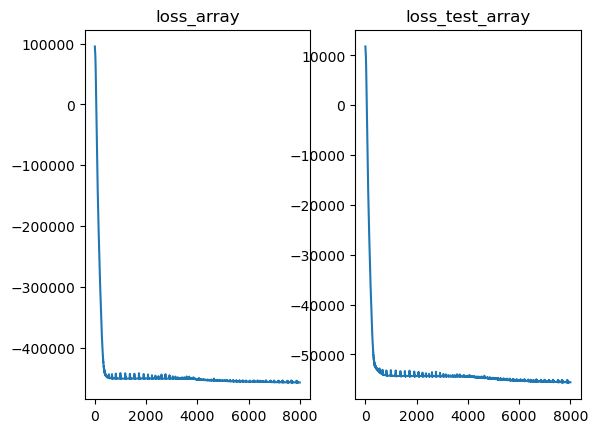

In [44]:
import torch.optim as optim
high = True
nets_g5 = [NetworkNoise3()]
epochs = 8000

loss_array = {}
loss_test_array = {}
i=0
# train_full_tensors_n, mean, std = normalize_tensor(train_full_tensors)
# test_full_tensors_n, mean, std = normalize_tensor(test_full_tensors)
train_dataset = BatchNoiseDataset((train_full_tensors*0.5).reshape(dataset_size,1,-1),g_t[i])
test_dataset = BatchNoiseDataset((test_full_tensors*0.5).reshape(dataset_size,1,-1),g_t[i])

#Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True) #todo: numbers
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)


nets_g5,loss_array_high,loss_test_array_high = train(steps=[0],nets=nets_g5,train_loader=train_loader,test_loader=test_loader)

plot_loss(loss_array_high,loss_test_array_high,0)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CausalConv1d(nn.Conv1d):
    """
    A standard causal convolution:
    output[t] depends on x[:t], not on x[t+1:].
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        padding = (kernel_size - 1) * dilation
        super().__init__(in_channels, out_channels, kernel_size=kernel_size, 
                         dilation=dilation, padding=padding, **kwargs)
        
    def forward(self, x):
        # Remove extra padding at the end to maintain causality
        out = super().forward(x)
        if self.padding[0] > 0:
            out = out[:, :, :-self.padding[0]]
        return out

class GatedResidualBlock(nn.Module):
    """
    A gated residual block similar to those used in WaveNet:
    - Two parallel causal convolutions: one for filter (tanh), one for gate (sigmoid).
    - The output of filter and gate is multiplied element-wise.
    - A residual connection is added to maintain stable gradients.
    - A skip connection is extracted for final output reconstruction.
    """
    def __init__(self, channels, kernel_size, dilation):
        super().__init__()
        self.conv_filter = CausalConv1d(channels, channels, kernel_size, dilation=dilation)
        self.conv_gate = CausalConv1d(channels, channels, kernel_size, dilation=dilation)
        
        # 1x1 convolutions for residual and skip connections
        self.conv_res = nn.Conv1d(channels, channels, 1)
        self.conv_skip = nn.Conv1d(channels, channels, 1)

        # Adding dropout for stability
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # x: (B, C, T)
        filter_out = torch.tanh(self.conv_filter(x))
        gate_out = torch.sigmoid(self.conv_gate(x))
        out = filter_out * gate_out
        out = self.dropout(out)
        
        # Residual connection
        res = self.conv_res(out) + x
        # Skip connection
        skip = self.conv_skip(out)
        return res, skip

class StrongerNetwork(nn.Module):
    def __init__(self, hidden_channels=16, kernel_size=15, dilations=[1, 2, 4, 8]):
        super().__init__()
        self.input_conv = CausalConv1d(1, hidden_channels, 1)  # Project input to hidden_channels
        
        # Stack of gated residual blocks with increasing dilations
        self.blocks = nn.ModuleList([
            GatedResidualBlock(hidden_channels, kernel_size, d) for d in dilations
        ])
        
        # Final projection to 2 channels (mean, log_var)
        self.post_conv = nn.Conv1d(hidden_channels, 2, 1)
        
    def forward(self, x, cur_gt=None):
        # x: (B, 1, T)
        x = self.input_conv(x)
        
        skip_connections = []
        for block in self.blocks:
            x, skip = block(x)
            skip_connections.append(skip)
        
        # Combine skip connections
        out = torch.relu(sum(skip_connections))
        out = self.post_conv(out)  # (B, 2, T)
        
        means = out[:,0,:]
        log_var = out[:,1,:]
        stds = torch.exp(0.5 * log_var)
        
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze(axis=1)[:,4:]
        means_ = expected_means.squeeze(axis=1)[:,3:-1]
        stds_ = expected_stds.squeeze(axis=1)[:,3:-1]

        exp_all = -(1/2)*((torch.square(wav_tensor - means_) / torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood

start 


/tmp/ipykernel_201053/174528573.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

0
Model 0 Epoch 20/20, Loss: 52039004.59375, test Loss: 11632.998046875
2560


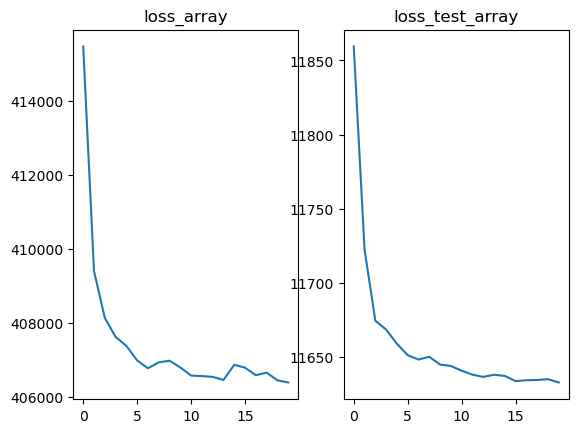

In [ ]:
import torch.optim as optim
high = True
nets_g5 = [StrongerNetwork()]
epochs = 20

loss_array = {}
loss_test_array = {}
i=0
# train_full_tensors_n, mean, std = normalize_tensor(train_full_tensors)
# test_full_tensors_n, mean, std = normalize_tensor(test_full_tensors)
train_dataset = BatchNoiseDataset((train_full_tensors*0.5).reshape(dataset_size,1,-1),g_t[i])
test_dataset = BatchNoiseDataset((test_full_tensors*0.5).reshape(dataset_size,1,-1),g_t[i])

#Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True) #todo: numbers
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)


nets_g5,loss_array_high,loss_test_array_high = train(steps=[0],nets=nets_g5,train_loader=train_loader,test_loader=test_loader)

plot_loss(loss_array_high,loss_test_array_high,0)

In [44]:
import pickle
# params_dict = {"nets": nets, "train_dataset": train_dataset, "test_dataset": test_dataset,"ar_coefs":ar_coefs, "loss_array":loss_array, "loss_test_array": loss_test_array, "ar_noise": ar_noise, "noise_scaling": noise_scaling_15, "snr": "15"}
with open('model_gpt.pickle', 'wb') as handle:
    pickle.dump(nets_g5[0], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [132]:
nets_g[0] = nets_g[0].to("cuda:3")
nets_g2[0] = nets_g2[0].to("cuda:3")
nets_g3[0] = nets_g3[0].to("cuda:3")
nets_g4[0] = nets_g4[0].to("cuda:3")
nets_g5[0] = nets_g5[0].to("cuda:3")
means2, stds2 = nets_g2[0](train_inputs4.to("cuda:3"),None)
means1, stds1 = nets_g[0](train_inputs4.to("cuda:3"),None)
means3, stds3 = nets_g3[0](train_inputs4.to("cuda:3"),None)
means4, stds4 = nets_g4[0](train_inputs4.to("cuda:3"),None)
means5, stds5 = nets_g5[0](train_inputs4.to("cuda:3"),None)


ll1 = nets_g[0].casual_loss(means1, stds1, train_inputs4.to("cuda:3")).mean()
ll2 = nets_g2[0].casual_loss(means2, stds2, train_inputs4.to("cuda:3")).mean()
ll3 = nets_g3[0].casual_loss(means3, stds3, train_inputs4.to("cuda:3")).mean()
ll4 = nets_g4[0].casual_loss(means4, stds4, train_inputs4.to("cuda:3")).mean()
ll5 = nets_g5[0].casual_loss(means5, stds5, train_inputs4.to("cuda:3")).mean()

print(ll1)
print(ll2)
print(ll3)
print(ll4)
print(ll5)

tensor(22727.0039, device='cuda:3', grad_fn=<MeanBackward0>)
tensor(23504.1543, device='cuda:3', grad_fn=<MeanBackward0>)
tensor(27429.0703, device='cuda:3', grad_fn=<MeanBackward0>)
tensor(22726.9805, device='cuda:3', grad_fn=<MeanBackward0>)
tensor(22726.9785, device='cuda:3', grad_fn=<MeanBackward0>)


In [71]:
for name, param in nets_g5[0].named_parameters():
    if param.requires_grad:
        print(name, param.data)

conv0.weight tensor([[[-0.0179, -0.0373, -0.0079,  0.0295,  0.0212, -0.0314, -0.0136,
           0.0498, -0.5523]],

        [[ 0.0537,  0.0114, -0.0078,  0.0697,  0.0725, -0.0199, -0.0191,
           0.0763, -0.1258]]], device='cuda:3')
conv0.bias tensor([-0.2529,  0.1292], device='cuda:3')
conv1.weight tensor([[[-3.6282e-02,  5.3642e-04,  7.8612e-05,  4.3221e-03,  2.0174e-02,
          -2.7745e-03,  9.5410e-04,  2.2033e-02, -3.2883e-01]],

        [[ 4.9308e-02,  7.4317e-02, -9.9745e-02, -1.0286e-02,  5.6769e-02,
          -6.1804e-02, -8.5391e-03,  4.8451e-02,  1.3416e-01]]],
       device='cuda:3')
conv1.bias tensor([-0.0553,  0.1759], device='cuda:3')
conv2.weight tensor([[[-0.0634, -0.1851, -0.1868,  0.1643, -0.2762,  0.0870,  0.1944,
          -0.1850,  0.1634],
         [-0.0170, -0.1103, -0.1891, -0.3419,  0.0492,  0.1255, -0.4342,
          -0.1515, -0.3954]],

        [[ 0.1482, -0.0215, -0.0160, -0.0698, -0.1002,  0.1981,  0.1889,
          -0.0583, -0.2765],
         [-0.0

In [45]:
model4=nets_g5[0]
model4.eval()
for batch_idx, (train_inputs4, gt_test) in enumerate(test_loader):
    break
# test_inputs, gt_test = test_dataset.__getitem__(j)
train_inputs4 = train_inputs4.to("cuda:2", dtype=torch.float)


In [47]:
train_inputs4.shape

torch.Size([1, 1, 16000])

In [46]:
train_inputs4[1,0,:15002]==train_inputs4[2,0,:15002]

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [48]:
long = 800
window = 1000
mu_array4 = torch.zeros((long+window+1))
sig_array4 = torch.zeros((long+window+1))

model4 = model4.to("cuda:2")
cur_input4 = train_inputs4[0,0,:15002].clone().view(1,1,-1)
cur_input4[0,0,window+1:] = 0
print(cur_input4[0,0,window])
print(cur_input4[0,0,window+1])
cur_input4 = cur_input4.to("cuda:2", dtype=torch.float)
print(cur_input4.shape)
# cur_input = cur_train[0,0,:window].view(1,1,-1)
for i in tqdm(range(train_inputs4.shape[2]-window)):
    if i >long:
        continue

    mu,sig = model4(cur_input4[0,0,:window+i+1].view(1,1,-1),g_t[j])
    mu_ = mu[0,-1]
    sig_ = sig[0,-1]
    
    mu_array4[window+i] = mu_
    sig_array4[window+i] = sig_
    added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
    # print(mu_,sig_,added)
    cur_input4[0,0,window+i+1] = added

    torch.cuda.empty_cache()

tensor(0., device='cuda:2')
tensor(0., device='cuda:2')
torch.Size([1, 1, 15002])


/tmp/ipykernel_166621/903781860.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(train_inputs4.shape[2]-window)):


  0%|          | 0/15000 [00:00<?, ?it/s]

In [61]:
sig_array4[window-2:window+20]

tensor([0.0000, 0.0000, 0.5646, 0.5343, 0.6060, 0.6096, 0.5787, 0.5700, 0.4977,
        0.5290, 0.5051, 0.5346, 0.4788, 0.4674, 0.4932, 0.5447, 0.4734, 0.5136,
        0.4558, 0.4594, 0.5666, 0.4989], grad_fn=<SliceBackward0>)

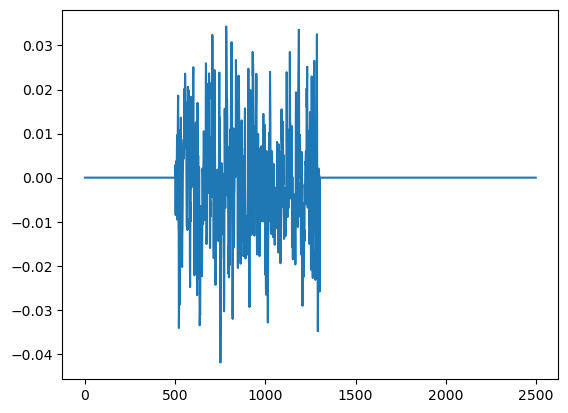

In [49]:
plot_this(cur_input4[0,0,window-500:window+2000].cpu().detach().numpy())

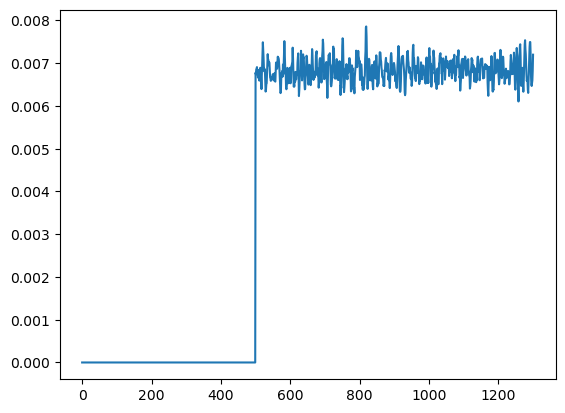

In [50]:
plot_this((sig_array4[window-500:window+2000]).cpu().detach().numpy())

In [49]:
sig_array4[window-2:window+4]

tensor([0.0000, 0.0000, 0.5208, 0.5295, 0.5330, 0.5224],
       grad_fn=<SliceBackward0>)

In [50]:
train_inputs4[0,0,window+4990:window+5000]

tensor([ 1.8934, -1.1883,  1.8217, -1.7287,  0.9667, -0.4488,  1.8015, -1.4541,
         0.9176, -0.3599], device='cuda:1')

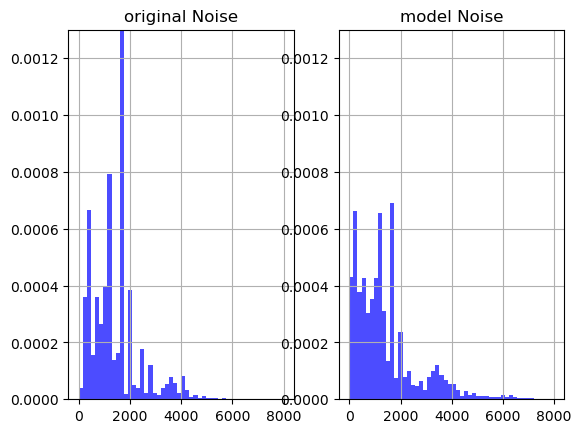

In [51]:
freqs1, magnitudes1 = signal.welch(train_inputs4[0,0,window:window+5000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input4[0,0,window:window+5000].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [36]:
with torch.no_grad():
    output_test_low_mean, output_test_low_std = (model4(train_inputs4, gt_test))
audio_output = torch.normal(output_test_low_mean, output_test_low_std).squeeze()

freqs1, magnitudes1 = signal.periodogram(train_inputs4[0,:].squeeze()[400:].cpu().numpy(), fs=16000)
freqs, magnitudes = signal.periodogram(audio_output[0,:].squeeze()[400:].cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

IndexError: too many indices for tensor of dimension 1

In [50]:
output_test_low_std.shape

torch.Size([8, 16000])

(array([5.000e+00, 1.000e+00, 1.400e+01, 1.900e+01, 4.800e+01, 6.800e+01,
        1.270e+02, 2.090e+02, 3.170e+02, 4.110e+02, 6.030e+02, 7.210e+02,
        8.790e+02, 1.032e+03, 1.123e+03, 1.117e+03, 1.257e+03, 1.192e+03,
        1.064e+03, 1.045e+03, 9.710e+02, 7.700e+02, 6.920e+02, 5.550e+02,
        4.840e+02, 3.150e+02, 2.510e+02, 1.940e+02, 1.450e+02, 1.130e+02,
        7.400e+01, 5.700e+01, 4.000e+01, 2.400e+01, 1.300e+01, 1.200e+01,
        8.000e+00, 6.000e+00, 9.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.36030853, 0.36904621, 0.37778389, 0.38652158, 0.39525926,
        0.40399694, 0.41273463, 0.42147231, 0.43020999, 0.43894768,
        0.44768536, 0.45642304, 0.46516073, 0.47389844, 0.48263612,
        0.49137381, 0.50011146, 0.50884914, 0.51758683, 0.52632451,
        0.53506219, 0.54379988, 0.55253756, 0.56127524, 0.57001293,
        0.57875061, 0.58748835, 0.59

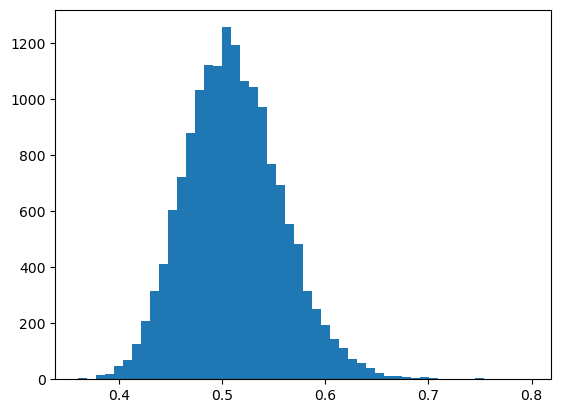

In [53]:
plt.hist(output_test_low_std[0,:].cpu(),bins=50)

In [ ]:
audio_output.shape

torch.Size([8, 560000])

In [191]:
from torch import nn



class SimpleAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # Initial value of 'a'
        self.b = nn.Parameter(torch.tensor(0.1))  # Initial value of 'b'
        # self.c = nn.Parameter(torch.tensor(0.1)) 
        # self.d = nn.Parameter(torch.tensor(0.1)) 

    def forward(self, x, cur_gt):
        means = torch.zeros_like(x)
        stds = torch.zeros_like(x)
        for i in range(x.shape[-1]):
            if i==1 or i==0:
                continue
            means[:,:,i] = self.a* x[:,:,i-1]#+self.d* x[:,:,i-2] +self.c
            stds[:,:,i] = self.b 
        return means, stds
    
    def forward_once(self, x, cur_gt):
        means = self.a* x[:,:,i-1]# +self.d* x[:,:,i-2] +self.c
        stds = self.b 
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze(axis=1)[:,3:]
        means_=expected_means.squeeze(axis=1)[:,3:]
        stds_ = expected_stds.squeeze(axis=1)[:,3:]


        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood   
    

In [192]:
train_full_tensors.shape

torch.Size([256, 560000])

start 


/tmp/ipykernel_147609/174528573.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/30 [00:00<?, ?it/s]

0
Model 0 Epoch 30/30, Loss: 156963.8955078125, test Loss: 9749.388671875
480


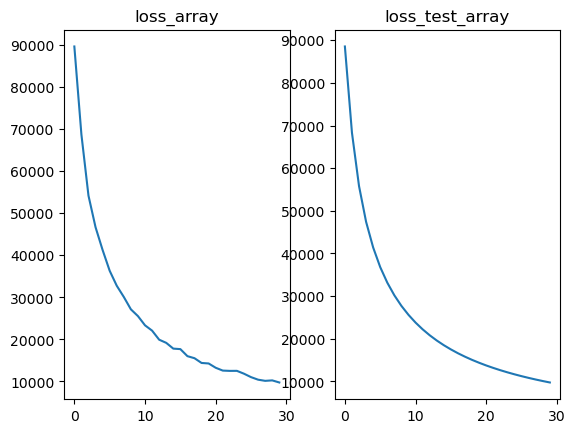

In [194]:
import torch.optim as optim
nets_g = [SimpleAR()]
epochs = 30

loss_array = {}
loss_test_array = {}
i=0
# train_full_tensors_n, mean, std = normalize_tensor(train_full_tensors)
# test_full_tensors_n, mean, std = normalize_tensor(test_full_tensors)
train_dataset = BatchNoiseDataset(train_full_tensors[:,:3000].reshape(dataset_size,1,-1),g_t[i])
test_dataset = BatchNoiseDataset(test_full_tensors[:,:3000].reshape(dataset_size,1,-1),g_t[i])

#Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True) #todo: numbers
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)


nets_g,loss_array_high,loss_test_array_high = train(steps=[0],nets=nets_g,train_loader=train_loader,test_loader=test_loader)

plot_loss(loss_array_high,loss_test_array_high,0)

In [195]:
model5 = nets_g[0]
model5.eval()
for batch_idx, (train_inputs4, gt_test) in enumerate(train_loader):
    break
# test_inputs, gt_test = test_dataset.__getitem__(j)
train_inputs4 = train_inputs4.to("cuda:1", dtype=torch.float)

In [196]:
# loss = model5.casual_loss( output_test_low_mean.to("cuda:1"), output_test_low_std.to("cuda:1"), train_inputs4).mean() ##.mean()

In [197]:
loss

NameError: name 'loss' is not defined

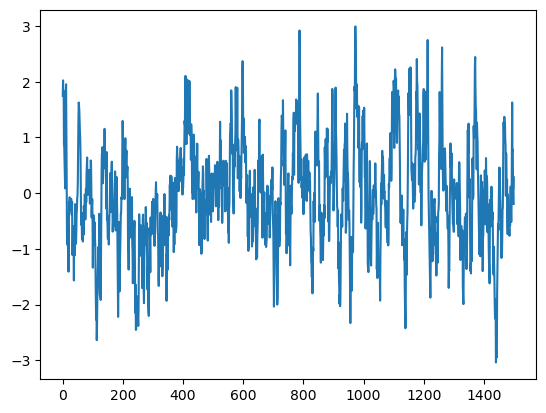

In [198]:
plot_this(cur_input4[0,0,window-500:window+1000].cpu().detach().numpy())

In [199]:
long = 999
window = 1000
mu_array4 = torch.zeros((long+window+1))
sig_array4 = torch.zeros((long+window+1))

model5 = model5.to("cuda:1")
cur_input4 = train_inputs4[0,0,:3000].clone().view(1,1,-1)
cur_input4[0,0,window+1:] = 0
print(cur_input4[0,0,window])
print(cur_input4[0,0,window+1])
cur_input4 = cur_input4.to("cuda:1", dtype=torch.float)
print(cur_input4.shape)
# cur_input = cur_train[0,0,:window].view(1,1,-1)
for i in tqdm(range(long)):
    if i >long:
        continue

    mu,sig = model5.forward_once(cur_input4[0,0,:window+i+1].view(1,1,-1),g_t[j])
    mu_ = mu[0,-1]
    sig_ = sig
    
    mu_array4[window+i] = mu_
    sig_array4[window+i] = sig_
    added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
    # print(mu_,sig_,added)
    cur_input4[0,0,window+i+1] = added

    torch.cuda.empty_cache()

tensor(0.6467, device='cuda:1')
tensor(0., device='cuda:1')
torch.Size([1, 1, 3000])


/tmp/ipykernel_147609/615584594.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(long)):


  0%|          | 0/999 [00:00<?, ?it/s]

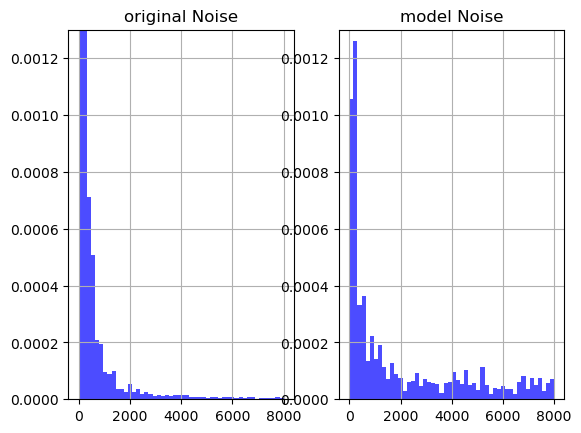

In [200]:
freqs1, magnitudes1 = signal.welch(train_inputs4[0,0,window:window+5000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input4[0,0,window:window+5000].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [201]:
for name, param in nets_g[0].named_parameters():
    if param.requires_grad:
        print(name, param.data)

a tensor(0.3514, device='cuda:1')
b tensor(0.2607, device='cuda:1')


In [ ]:
#LMS

In [49]:

batch_size_ = 1
order=1
white_noise = torch.normal(0, 1, size=(1, 5001))

# Expand AR coefficients for batch processing
ar_coefs = 0.9  # Shape: (batch_size, order)


# Initialize the AR noise tensor
ar_noise_ = torch.zeros_like(white_noise)

# Iterate across time steps to compute AR noise
for t in range(1, 5001):
    past_values = ar_noise_[:, t - 1:t]  # Shape: (batch_size, order)
    # Compute AR noise using matrix multiplication
    ar_noise_[:, t] = (past_values * ar_coefs).sum(dim=1) + white_noise[:, t]

# Remove the first `order` values to discard transient
ar_noise_ =  ar_noise_[:, order:]

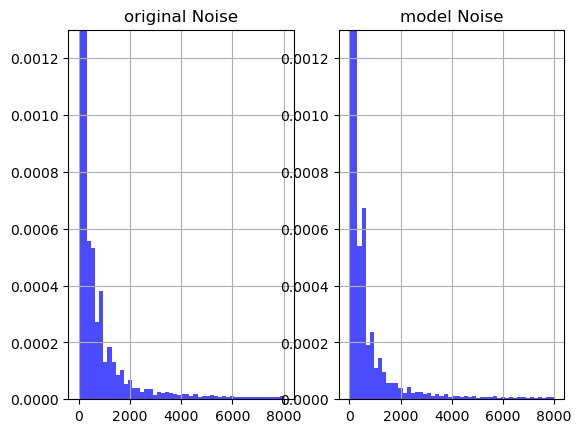

In [51]:
freqs1, magnitudes1 = signal.welch(train_inputs4[0,0,window:window+5000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(ar_noise_.squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()